# Regime-PCMCI: Detecting causal regimes from multivariate time series

Main reference: Elena Saggioro, Jana de Wiljes, Marlene Kretschmer, Jakob Runge; Reconstructing regime-dependent causal relationships from observational time series. Chaos 1 November 2020; 30 (11): 113115. https://doi.org/10.1063/5.0020538

The following Nature Review Earth and Environment paper provides an overview of causal inference for time series in general: https://github.com/jakobrunge/tigramite/blob/master/tutorials/Runge_Causal_Inference_for_Time_Series_NREE.pdf

In [72]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
from sklearn.linear_model import LinearRegression


import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.rpcmci import RPCMCI


from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

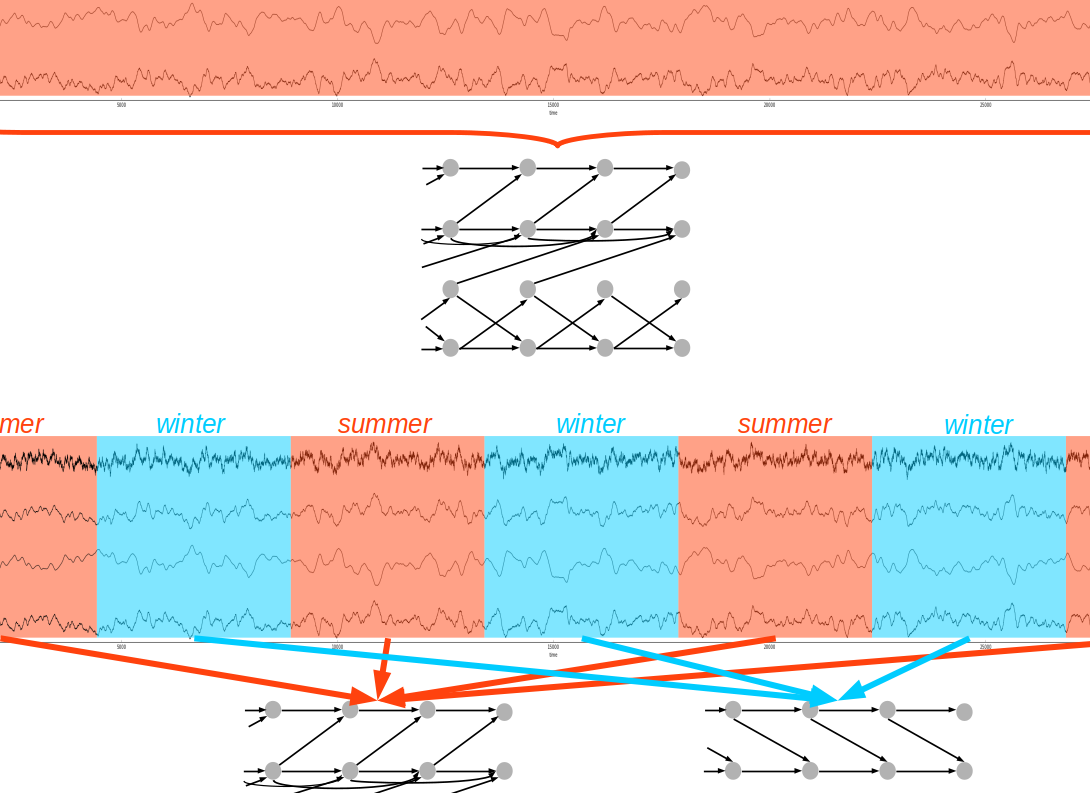

Below we generate data in which the underlying causal structure alternates between two regimes that are referred to as winter half year and summer half year. In particular, the two regimes differ in that one causal effect is of opposite sign in the two regimes.

Importantly, Regime-PCMCI does not require a periodic structure of regimes, they can be arbitrarily distributed across time. However, there are assumptions on the number of regimes and their persistency. For the assumptions of R-PCMCI, see the paper above.

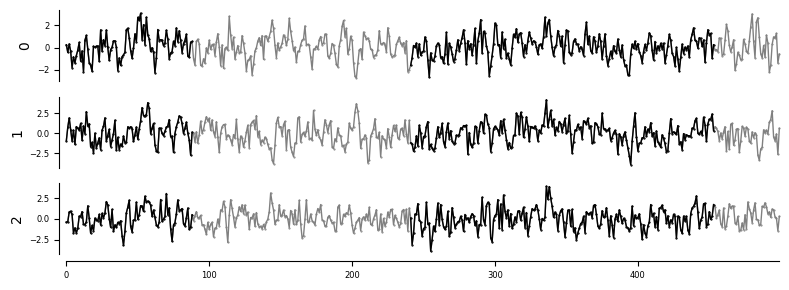

In [2]:
np.random.seed(43)
T = 500
var_names = [r'$X^1$', r'$X^2$', r'$X^3$']
data = np.random.randn(T, 3)
data_mask = np.zeros(data.shape)
for t in range(1, T):
    if (t % 365) < 3*30 or (t % 365) > 8*30: 
        # Winter half year
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] + 0.7*data[t-1, 0]
        data[t, 2] +=  0.3*data[t-1, 2] + 0.7*data[t-1, 0]
    else:
        # Summer half year
        data_mask[[t, t-1]] = True
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1]  - 0.7*data[t-1, 0]
        data[t, 2] +=  0.3*data[t-1, 2] 

T, N = data.shape
# print data_mask[:100, 0]
datatime = np.arange(T)
dataframe_plotting = pp.DataFrame(data, mask=data_mask)
tp.plot_timeseries(dataframe_plotting, figsize=(8,3), grey_masked_samples='data'); plt.show()


## Learning graphs if causal regimes are known

Let's first reconstruct the causal graphs belonging to the two regimes by explicitly including knowledge about the regimes via *masking*. See the tutorial on masking in the folder dataset_challenges.

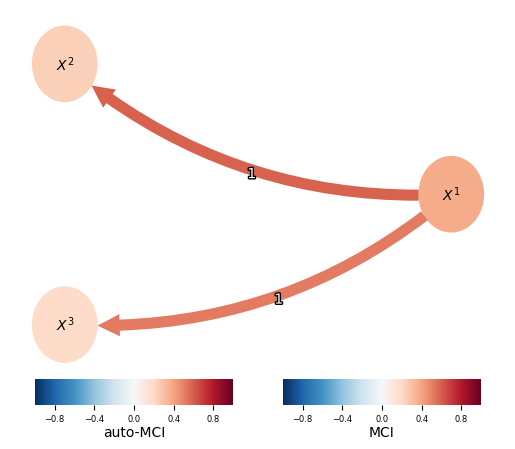

In [3]:
# First mask out the summer
pcmci = PCMCI(dataframe=dataframe_plotting, 
              cond_ind_test=ParCorr(mask_type='y'))
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

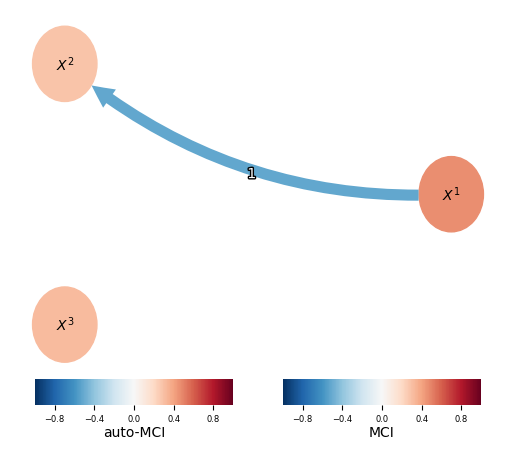

In [4]:
# Then mask out the winter
dataframe_plotting.mask[0] = dataframe_plotting.mask[0] == False
pcmci = PCMCI(dataframe=dataframe_plotting, 
              cond_ind_test=ParCorr(mask_type='y'))
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

## Ignore regimes and learn graph over all data

Just as an illustration.

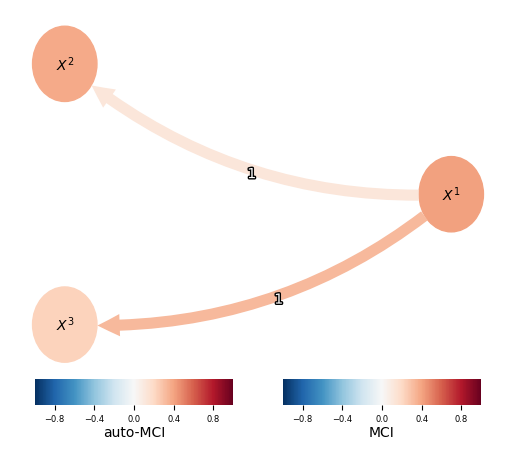

In [5]:
pcmci = PCMCI(dataframe=pp.DataFrame(data), 
              cond_ind_test=ParCorr())
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

## Learn regimes and corresponding causal graphs

Now run RPCMCI to automatically detect the causal regimes without assuming them with masking.

In [6]:
# Dataframe init. Note that for R-PCMCI no data mask can be used. 
# The mask will internally be overwritten to learn regimes
dataframe = pp.DataFrame(data)

# Init RPCMCI with the dataframe, a conditional independence test for use in PCMCI, 
# and a prediction_model which is used to predict each variable given its learned parents. This prediction 
# is then used inside the regime learning optimization step.
rpcmci = RPCMCI(dataframe=dataframe, 
                cond_ind_test=ParCorr(),
                prediction_model=LinearRegression(),
                verbosity=1)

# RPCMCI parameters, see paper
num_regimes = 2
max_transitions = 4
switch_thres = 0.05
num_iterations = 20
max_anneal = 10
tau_min = 1
tau_max = 1
pc_alpha = 0.2
alpha_level = 0.01
n_jobs = -1     # uses joblib for parallelization, here all available cpus are used

# Run RPCMCI
results = rpcmci.run_rpcmci(
    num_regimes=num_regimes, max_transitions=max_transitions, 
    switch_thres=switch_thres, 
    num_iterations=num_iterations, max_anneal=max_anneal, 

    tau_min=tau_min, tau_max=tau_max,
    pc_alpha=pc_alpha, alpha_level=alpha_level, 
    n_jobs=n_jobs
    )

if results is None:
    print("All annealings resulted in errors. Increase annealing and tune other parameters!")
else:
    print("Done!")


################# Annealing iteration a = 0 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 1 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1

################# Annealing iteration a = 2 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1
################ Regime k = 1

################# Annealing iteration a = 3 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1

Optimal objective: reached.
Difference in abs value between the previous and current gamma (shape num_regimesxT) : 503.5399195755775

###### Optimization step q = 1
################ Regime k = 0
################ Regime k = 1

Optimal objective: reached.
Difference in abs value between the previous and current gamma (shape num_regimesxT) : 490.9369752339443

###

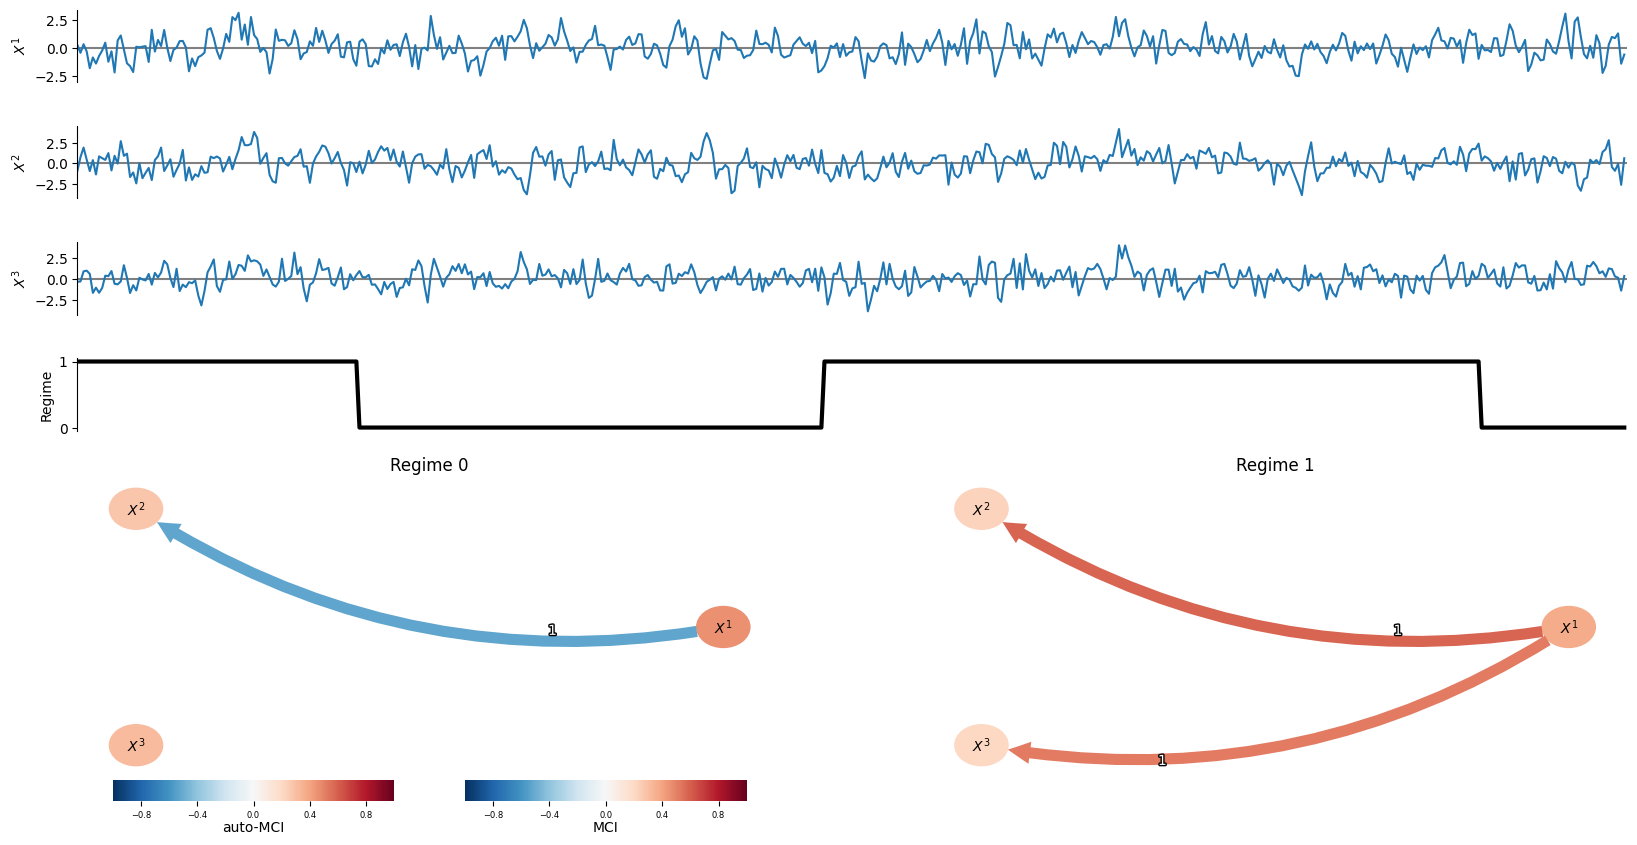

In [7]:
regimes = results['regimes'].argmax(axis=0)
n_regimes = len(results['causal_results'])

# Create nice Mosaic plot
mosaic = [['data %s' %j for i in range(n_regimes)] for j in range(N+1)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_regimes)])

fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    ax.plot(datatime, data[:,j])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])
    
# Regime variable
ax = axs['data %s' %N]
ax.plot(datatime, regimes.astype('int'), lw=3, color='black')
for loc, spine in ax.spines.items():
    if loc != 'left':
        spine.set_color("none")
ax.xaxis.set_ticks([]) 
ax.yaxis.set_ticks(range(n_regimes))   
ax.set_xlim(0., T)
ax.set_ylabel("Regime")
    
# Causal graphs for each regime
for w in range(n_regimes):
    if w == 0: show_colorbar=True
    else: show_colorbar = False
    tp.plot_graph(graph=results['causal_results'][w]['graph'], 
                  val_matrix=results['causal_results'][w]['val_matrix'], 
                  show_colorbar=show_colorbar,
                  var_names=var_names,
                  fig_ax=(fig, axs['graph %s' %w]))
    axs['graph %s' %w].set_title("Regime %d" %w, pad=-4)

fig.subplots_adjust(hspace=0.6)
plt.show()

The regimes are reconstructed well here. For any real data application, we suggest to construct some toy data with similar properties and then explore which parameters work best for RPCMCI. 

We also would like to note that, at present, we have no theoretical results on which types of regime changes are identifiable with this method. However, we demonstrate in numerical experiments, that it works for changes in the graph structure, or the magnitude and sign of links.

# Reproducting ENSO and AIR(All-India Rainfall) experiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

# Function to remove seasonal mean and divide by seasonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds = None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly

## Loading the data

### Loading ENSO

In [38]:
nino34 = np.loadtxt("nino3.4_2025.dat.txt")

(1859, 2)


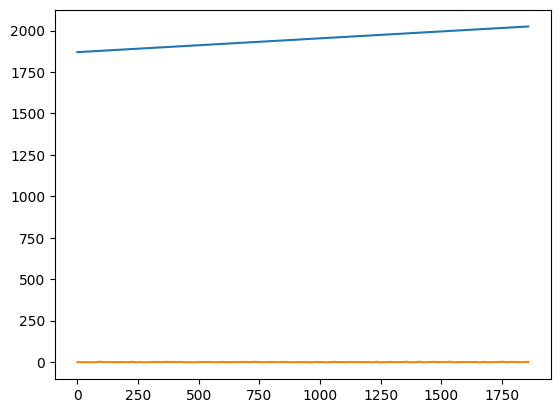

In [5]:
# summarize the data
print(nino34.shape)

# plot the data
plt.plot(nino34)

### Loading AIR

In [39]:
AIR = np.loadtxt("AIR.dat.txt")

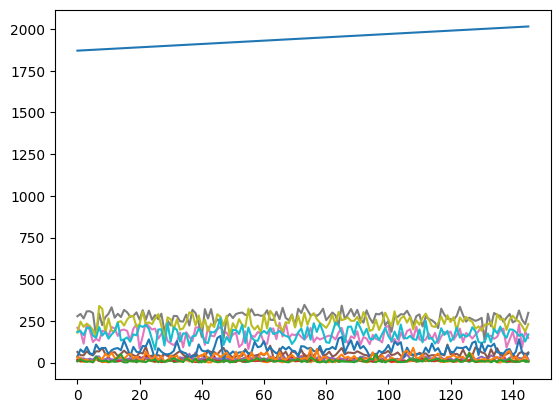

In [33]:
plt.plot(AIR)

In [40]:
# now the air data has the columns YEAR, Rain-January, Rain-February, Rain-March, Rain-April, Rain-May, Rain-June, Rain-July, Rain-August, Rain-September, Rain-October, Rain-November, Rain-December
# we reshape it so to have only two columns: TIME and RAIN where each row is the value for eahc month in chronological order
start_year = AIR[0,0]

end_year = AIR[-1,0]


print(f"Start year: {start_year}, End year: {end_year}")

AIR = AIR[:,1:].reshape(-1,1)

# summarize the data
print(AIR.shape)

# add a time column
time = np.arange(start_year, end_year + 1, 1/12)

# add the time column to the data
AIR = np.hstack((time.reshape(-1,1), AIR))

Start year: 1871.0, End year: 2016.0
(1752, 1)


In [14]:
AIR

array([[1871.        ,   19.6       ],
       [1871.08333333,   10.7       ],
       [1871.16666667,   14.5       ],
       ...,
       [2016.75      ,   52.1       ],
       [2016.83333333,    8.        ],
       [2016.91666667,    7.        ]])

### Pre-processing
Making the data stationary (don't know yet if necessary)


In [ ]:
cycle_length = 12
smooth_width = cycle_length*10
if smooth_width is not None: 
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

data_here = anomalize(data_here, cycle_length=cycle_length)

### Join datasets



In [41]:
# cut the nino34 data to the same time period as the air data
nino34 = nino34[(nino34[:, 0] >= start_year) & (nino34[:, 0] < end_year + 1 )]

In [66]:
AIR[:,0] = AIR[:,0].round(2)

nino34[:,0] = nino34[:,0].round(2) 

In [70]:


assert nino34.shape[0] == AIR.shape[0], f"Number of months are different: Nino34: {nino34.shape[0]}, AIR: {AIR.shape[0]}"
print (f"{nino34.shape[0]} ,  {AIR.shape[0]}")

# assert the the number of month for the first and the last year are the same for both datasets

nino_first_y_months = nino34[(nino34[:,0] >= start_year) & (nino34[:,0] < start_year + 1)].shape[0]

AIR_first_y_months = AIR[(AIR[:,0] >= start_year) & (AIR[:,0] < start_year + 1)].shape[0]

assert nino_first_y_months == AIR_first_y_months, f"Number of months for the first year are different: Nino34: {nino_first_y_months}, AIR: {AIR_first_y_months}"

nino_last_y_months = nino34[(nino34[:,0] >= end_year) & (nino34[:,0] < end_year+1)].shape[0]

AIR_last_y_months = AIR[(AIR[:,0] >= end_year ) & (AIR[:,0] < end_year+1)].shape[0]

assert nino_last_y_months == AIR_last_y_months, f"Number of months for the last year are different: Nino34: {nino_last_y_months}, AIR: {AIR_last_y_months}"

1752 ,  1752


In [71]:
# join datasets
data = np.hstack((AIR, nino34[:,1].reshape(-1,1)))

## Applying regime-PCMCI to the climate data

In [83]:
# Dataframe init. Note that for R-PCMCI no data mask can be used. 
# The mask will internally be overwritten to learn regimes
dataframe = pp.DataFrame(data[:,1:])

# Init RPCMCI with the dataframe, a conditional independence test for use in PCMCI, 
# and a prediction_model which is used to predict each variable given its learned parents. This prediction 
# is then used inside the regime learning optimization step.
rpcmci = RPCMCI(dataframe=dataframe, 
                cond_ind_test=ParCorr(),
                prediction_model=LinearRegression(),
                verbosity=1)

# RPCMCI parameters, see paper
num_regimes = 2
max_transitions = 4
switch_thres = 0.05
num_iterations = 20
max_anneal = 10
tau_min = 1
tau_max = 1
pc_alpha = 0.2
alpha_level = 0.01
n_jobs = -1     # uses joblib for parallelization, here all available cpus are used

# Run RPCMCI
results = rpcmci.run_rpcmci(
    num_regimes=num_regimes, max_transitions=max_transitions, 
    switch_thres=switch_thres, 
    num_iterations=num_iterations, max_anneal=max_anneal, 

    tau_min=tau_min, tau_max=tau_max,
    pc_alpha=pc_alpha, alpha_level=alpha_level, 
    n_jobs=n_jobs
    )

if results is None:
    print("All annealings resulted in errors. Increase annealing and tune other parameters!")
else:
    print("Done!")


################# Annealing iteration a = 0 ####################


################# Annealing iteration a = 1 ####################


###### Optimization step q = 0
################ Regime k = 0

###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 8 ####################


################# Annealing iteration a = 2 ####################


################# Annealing iteration a = 5 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 3 ####################


###### Optimization step q = 0
################ Regime k = 0

###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 7 ####################


###### Optimization step q = 0
################ Regime k = 0

###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 4 ####################


###### Optimization step q = 

In [88]:
T, N = data[:,1:].shape

var_names = ['Rain', 'Nino34']

In [89]:
T, N

(1752, 2)

In [91]:
datatime = data[:,0]

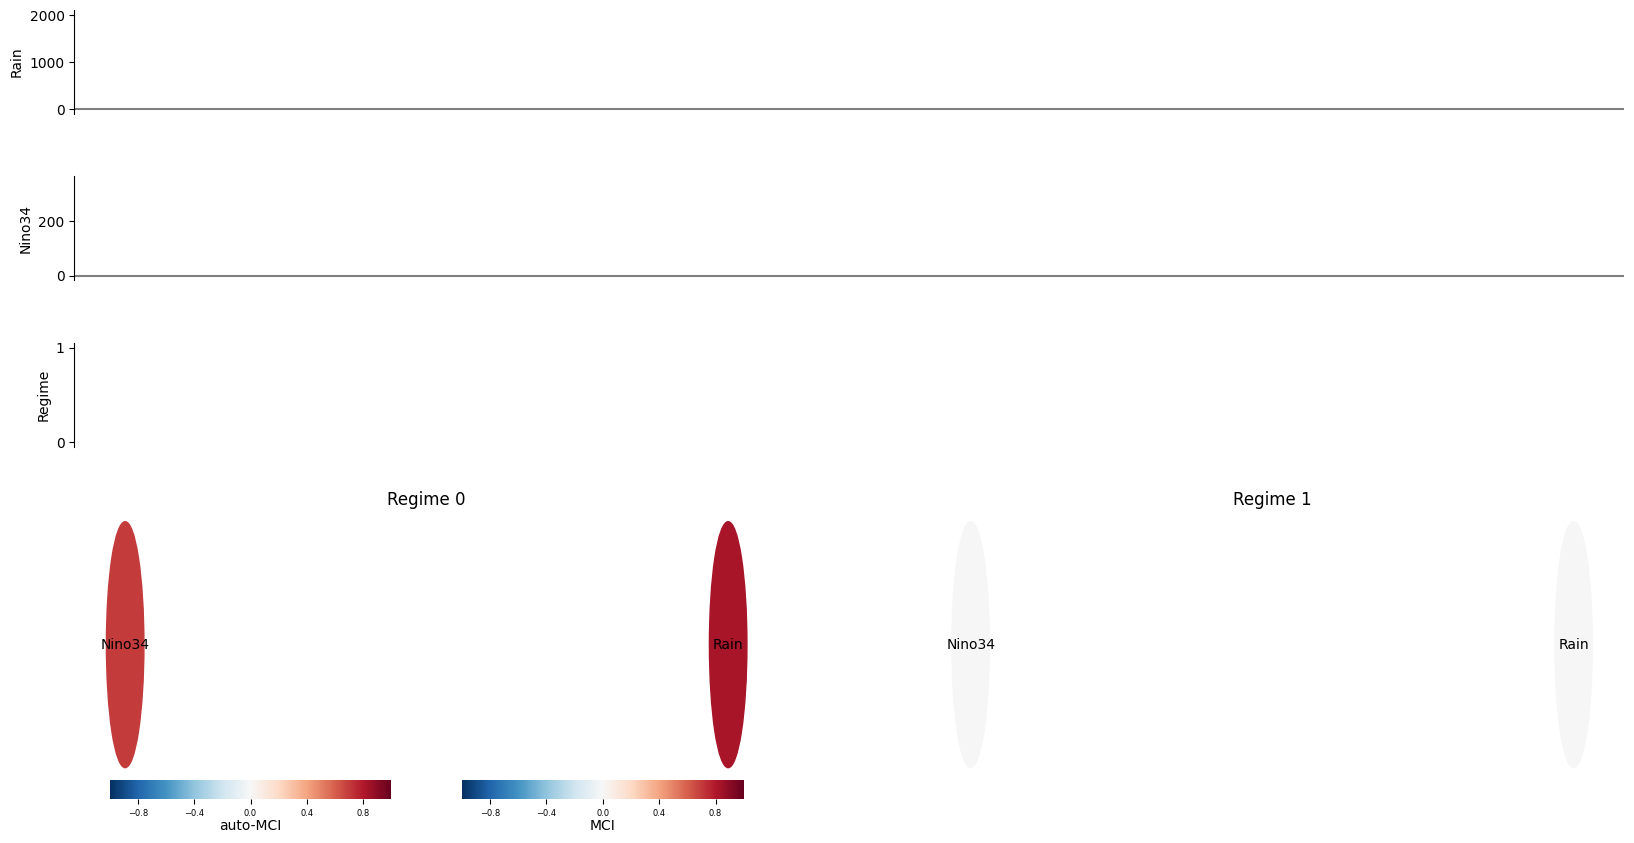

In [92]:
regimes = results['regimes'].argmax(axis=0)
n_regimes = len(results['causal_results'])



# Create nice Mosaic plot
mosaic = [['data %s' %j for i in range(n_regimes)] for j in range(N+1)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_regimes)])

fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    ax.plot(datatime, data[:,j])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])
    
# Regime variable
ax = axs['data %s' %N]
ax.plot(datatime, regimes.astype('int'), lw=3, color='black')
for loc, spine in ax.spines.items():
    if loc != 'left':
        spine.set_color("none")
ax.xaxis.set_ticks([]) 
ax.yaxis.set_ticks(range(n_regimes))   
ax.set_xlim(0., T)
ax.set_ylabel("Regime")
    
# Causal graphs for each regime
for w in range(n_regimes):
    if w == 0: show_colorbar=True
    else: show_colorbar = False
    tp.plot_graph(graph=results['causal_results'][w]['graph'], 
                  val_matrix=results['causal_results'][w]['val_matrix'], 
                  show_colorbar=show_colorbar,
                  var_names=var_names,
                  fig_ax=(fig, axs['graph %s' %w]))
    axs['graph %s' %w].set_title("Regime %d" %w, pad=-4)

fig.subplots_adjust(hspace=0.6)
plt.show()

In [80]:
N

3